# ABIDE subtype prototype
This is a notebook to set up the framework to conduct the large scale subtype analysis I plan with ABIDE. The goal for this notebook is to:

- create functions to deal with recurring tasks
- parallelize computation heavy and memory moderate tasks
- visualize and save the average subtype maps on disk

Specific to this project are these steps:

1. build similarity matrix of subjects based on individual network maps (scores, seed, dual regression)
2. cluster similarity matrix into 7 subgroups
3. compute the average cluster maps, also __subtypes__
4. generate individual weights for each subtype by computing the spatial correlation of individual maps with the subtype
5. run a GLM with the factors of site, motion and some diagnostic categories.
6. Investigate the individual factors with post-hoc contrasts and plot the results
7. Compare the model solutions of different network maps
8. Save the subtype maps as nifti objects and display them

In [128]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from matplotlib import pyplot as plt
from sklearn import linear_model as slin

In [129]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [130]:
# Paths
subtypes = 4
scale = 7
network = 2
net_id = network - 1
template = '*_fmri_{:07d}_session_1_run1_{}.nii.gz'
data_path = '/data1/abide/Out/Scores/sc{:02d}/time'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_3box_189_sample.csv'
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
map_types = ['stability_maps', 'rmap_part', 'dual_regression']
map_type = map_types[1]

In [131]:
# Load the mask
m_img = nib.load(mask_path)
mask = m_img.get_data()
mask = mask!=0
n_vox = np.sum(mask)

In [132]:
# Loop through the subject ID's and find the corresponding 
# files. If there is no file, drop the subject
drop_id = list()
path_list = list()
pheno = pd.read_csv(pheno_path)
for index, row in pheno.iterrows():
    s_id = row['SUB_ID']
    s_path = glob.glob(os.path.join(data_path, map_type, template.format(s_id, map_type)))
    if s_path:
        path_list.append(s_path[0])
    else:
        drop_id.append(index)
        continue
clean_pheno = pheno.drop(drop_id)

In [133]:
len(pheno.index)

189

In [134]:
n_files = len(path_list)
# Prepare the storage matrix
net_mat = np.zeros((n_vox, n_files))
# Go through the files
for index, s_path in enumerate(path_list):
    f_net = nib.load(s_path).get_data()[mask][..., net_id]
    net_mat[..., index] = f_net
net_mat = net_mat - np.mean(net_mat,0)

In [135]:
net_mat.shape

(45309, 189)

In [136]:
# Make a correlation matrix of the subjects
corr_sub = np.corrcoef(net_mat, rowvar=0)
link_sub = scl.hierarchy.linkage(corr_sub, method='ward')
part_sub = scl.hierarchy.fcluster(link_sub, subtypes, criterion='maxclust')

## Visualize the correlation matrix

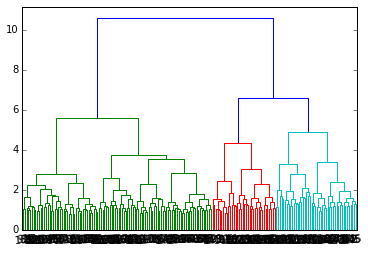

In [137]:
a = scl.hierarchy.dendrogram(link_sub, color_threshold=6)

[]

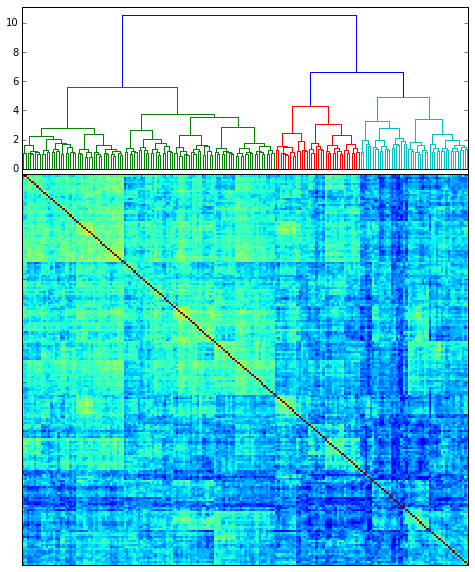

In [138]:
f = plt.figure(figsize=(8,10))
ax = f.add_subplot(111)
subdend = bb.visu.add_subplot_axes(ax, [0, 0.71, 1, 0.29])
submat = bb.visu.add_subplot_axes(ax, [0, 0, 1, 0.7])
Z1 = scl.hierarchy.dendrogram(link_sub, ax=subdend, color_threshold=6)
idx = Z1['leaves']
tmp = corr_sub[idx, :]
show_corr = tmp[:, idx]
submat.matshow(show_corr, aspect='auto')
subdend.set_xticklabels([])
submat.set_xticklabels([])
submat.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticklabels([])

The dendrogram looks like two subtypes would be a good place to start, more are probably possible.

_The plot still lacks a color bar_

## Run a GLM on the partition with diagnosis, motion and site as factors

In [139]:
# Make the average of the subtypes
sbt_avg = np.zeros((n_vox, subtypes))
for idx in range(subtypes):
    sub_id = np.unique(part_sub)[idx]
    sbt_avg[..., idx] = np.mean(net_mat[...,part_sub==sub_id],1)

In [140]:
# Generate the individual weights
y_stp = np.zeros((n_files, subtypes))
for s_id in range(subtypes):
    type_map = sbt_avg[:, s_id]
    y_stp[:, s_id] = np.array([np.corrcoef(type_map, net_mat[:,x])[0,1] for x in range(n_files)])

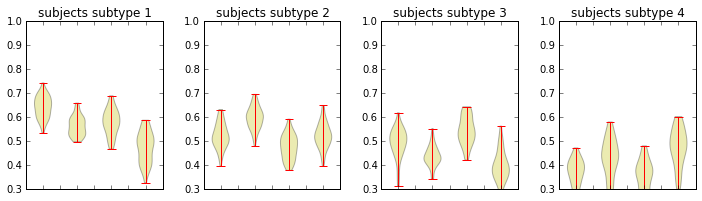

In [141]:
# Show the weights by subtype
fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
for i, stp in enumerate(np.unique(part_sub)):
    ax = fig.add_subplot(gs[0,i])
    ax.set_ylim([0.3, 1])
    ax.set_xticklabels([])
    # Take a subsample of the data, fitting the current subtype
    stp_data = y_stp[part_sub==stp,:]
    tmp = ax.violinplot(stp_data)
    ax.set_title('subjects subtype {}'.format(i+1))

Alright, the weights are highest for the subtype that the subjects are assigned to. That makes sense but isn't very interesting. It's more interesting to see that the weights are so close together and also that there are strong main effects of the subjects associated with one subtype.

Subjects in subtype 1 are most similar to subtype 1 but the other two follow close behind. Also in absolute terms the correlation scores are not as high as those of the subjects in subtype 3. I'm not sure how to interpret this. So while the subjects in subtype 3 are most correlated with their own subtype, they are - in absolute terms - still more correlated with subtype 1 than the subjects in subtype 1 themselves. __What does that mean__?

It probably means that subtype 1 collects a bunch of outliers that don't fit to the rest of the sample. If the subtypes are labeled in the same way as the dendrogram further up, that would make a lot of sense. So subtype 3 collects all subjects that are pretty similar to anything else in the sample and also quite homogeneous. On the other hand, subjects in subtype 1 are probably more heterogeneous. And subtype 2 is somewhere in between.

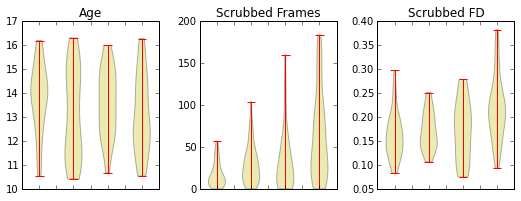

In [142]:
# Do one more run, but look at motion
fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(1, subtypes, wspace=0.3)
ages = [clean_pheno.loc[part_sub==stp]['AGE_AT_SCAN'].values for stp in np.unique(part_sub)]
frames = [clean_pheno.loc[part_sub==stp]['frames_scrubbed '].values for stp in np.unique(part_sub)]
motion = [clean_pheno.loc[part_sub==stp]['FD_scrubbed'].values for stp in np.unique(part_sub)]
# Age
ax_age = fig.add_subplot(gs[0,0])
ax_age.set_xticklabels([])
tmp = ax_age.violinplot(ages)
ax_age.set_title('Age')
# Age
ax_frame = fig.add_subplot(gs[0,1])
ax_frame.set_xticklabels([])
tmp = ax_frame.violinplot(frames)
ax_frame.set_title('Scrubbed Frames')
# Age
ax_motion = fig.add_subplot(gs[0,2])
ax_motion.set_xticklabels([])
tmp = ax_motion.violinplot(motion)
ax_motion.set_title('Scrubbed FD')

Alright, so in terms of age, they are quite similar. The fact that the distributions are not completely identicalis not that striking. After all, the original sample was almost uniform. So if there is an inbalance, it will be in each subtype. The motion part is more interesting. Subjects in subtype 1 seem to be considerably more affected by motion than the other two subtypes. After scrubbing, this seems to be less of an issue but they still show the stronges motion effect. I wonder what these graphs would look like with other methods.

## Run a GLM on the partition with diagnosis, motion and site as factors

In [143]:
# Generate the factor matrix
factors = ['DX_GROUP', 'AGE_AT_SCAN', 'FD_scrubbed']

# Make dummy variables for the site factor
site_factor = pd.get_dummies(clean_pheno['SITE_ID'])
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = clean_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

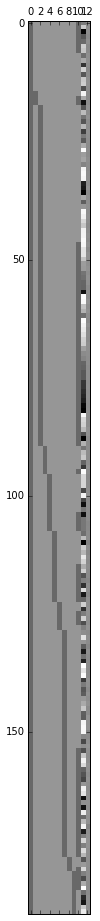

In [144]:
# Visualize the model matrix
plt.matshow(glm_pheno, cmap=cm.Greys)

In [145]:
# Run the model for subtype 1
model_sbt1 = sm.OLS(y_stp[:,0], glm_pheno)
results_sbt1 = model_sbt1.fit()
print(results_sbt1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     9.142
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           1.45e-13
Time:                        10:59:37   Log-Likelihood:                 185.19
No. Observations:                 189   AIC:                            -344.4
Df Residuals:                     176   BIC:                            -302.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7533      0.038     19.699      

In [146]:
# Test if the site dummys have larger parameter estimates than diagnosis
contrast = np.zeros((2,13))
#contrast[0,1:10] = -1
#contrast[0,10] = 9
#contrast[1,11] = 1
#contrast[1,12] = -1

In [147]:
contrast = np.zeros((1,13))
contrast[0,0] = 1
contrast[0,1] = -1

In [148]:
results_sbt1.t_test(contrast)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
c0             0.9217      0.077     11.949      0.000         0.769     1.074

In [149]:
# Run the model for subtype 2
model_sbt2 = sm.OLS(y_stp[:,1], glm_pheno)
results_sbt2 = model_sbt2.fit()
print(results_sbt2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     9.930
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           1.06e-14
Time:                        10:59:37   Log-Likelihood:                 222.61
No. Observations:                 189   AIC:                            -419.2
Df Residuals:                     176   BIC:                            -377.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.6520      0.031     20.782      

In [150]:
# Run the model for subtype 3
model_sbt3 = sm.OLS(y_stp[:,2], glm_pheno)
results_sbt3 = model_sbt3.fit()
print(results_sbt3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     7.955
Date:                Mon, 13 Jul 2015   Prob (F-statistic):           8.56e-12
Time:                        10:59:37   Log-Likelihood:                 201.55
No. Observations:                 189   AIC:                            -377.1
Df Residuals:                     176   BIC:                            -334.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.7337      0.035     20.918      